In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/modelb7/modelB7_2_step2.hdf5
/kaggle/input/sf-dl-car-classification/train.zip
/kaggle/input/sf-dl-car-classification/sample-submission.csv
/kaggle/input/sf-dl-car-classification/test.zip
/kaggle/input/sf-dl-car-classification/train.csv


In [2]:
!nvidia-smi

Tue Apr 13 07:01:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    31W / 250W |      0MiB / 16280MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **SETUP**

Установим необходимые библиотеки

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import zipfile
import csv
import sys
import os


import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
import tensorflow.keras.models as M
import tensorflow.keras.layers as L
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import *

from sklearn.model_selection import train_test_split, StratifiedKFold

import PIL
from PIL import ImageOps, ImageFilter
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['modelb7', 'sf-dl-car-classification']
Python       : 3.7.9 | packaged by conda-forge | (default, Feb 13 2021, 20:03:11) 
Numpy        : 1.19.5
Tensorflow   : 2.4.1
Keras        : 2.4.0


Запишем основные настройки для удобства дальнейшей работы

In [4]:
EPOCHS               = 10  # эпох на обучение
BATCH_SIZE           = 64 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/sf-dl-car-classification/'
PATH = "../working/car/" # рабочая директория



In [5]:
RANDOM_SEED = 42

# **EDA Проведем разведовательный анализ имеющихся данных**

In [6]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [14]:
train_df.Category.value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

Имеем в тренировочном датасете 10 категорий картинок. Распределение по категориям относительно равномерное.

In [15]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


In [7]:
print('Распаковываем картинки')
# Will unzip the files so that you can see them..
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile("../input/sf-dl-car-classification/"+data_zip,"r") as z:
        z.extractall(PATH)
        
print(os.listdir(PATH))

Распаковываем картинки
['train', 'test_upload']


Пример картинок (random sample)


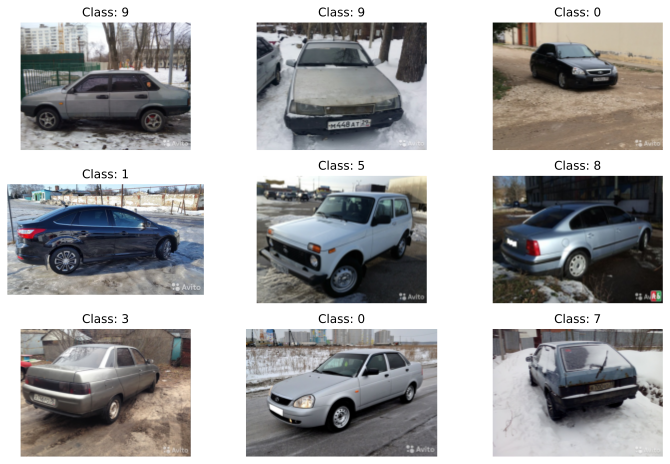

In [17]:
print('Пример картинок (random sample)')
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=9)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(3,3, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

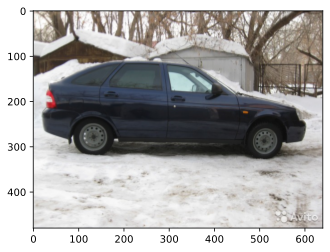

(640, 480)

In [12]:
image = PIL.Image.open(PATH+'/train/0/100380.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

# **Проведем подготовку данных для дальнейшего исследования**

Поскольку данных не очень много добавим аугментацию. Дополнительные библиотеки аугментации рассмотрим позднее

In [9]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range = 5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    validation_split=VAL_SPLIT, # set validation split
    horizontal_flip=False)

test_datagen = ImageDataGenerator(rescale=1. / 255)

**Генерация данных (завернем наши данные в генератор)**

In [10]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


# **Строим модель**

In [20]:
base_model = Xception(weights='imagenet', include_top=False, input_shape = input_shape)

83689472/83683744 [==============================] - 1s 0us/step


In [21]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [22]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
x = Dropout(0.25)(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(CLASS_NUM, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [24]:
print(len(model.layers))

136


In [25]:
len(model.trainable_variables)

158

**Обучаем модель**

In [27]:
checkpoint = ModelCheckpoint('best_model.hdf5', 
                             monitor = ['val_accuracy'], 
                             verbose = 1,
                             mode = 'max')
earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 4,
                          restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.25,
                              patience=2,
                              min_lr=0.0000001,
                              verbose=1,
                              mode='auto')
callbacks_list = [checkpoint, earlystop, reduce_lr]

In [28]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
207/207 [==============================] - 299s 1s/step - loss: 1.4423 - accuracy: 0.4877 - val_loss: 0.3670 - val_accuracy: 0.8678

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
207/207 [==============================] - 287s 1s/step - loss: 0.2250 - accuracy: 0.9180 - val_loss: 0.2533 - val_accuracy: 0.9137

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
207/207 [==============================] - 286s 1s/step - loss: 0.1047 - accuracy: 0.9603 - val_loss: 0.2532 - val_accuracy: 0.9150

Epoch 00003: saving model to best_model.hdf5
Epoch 4/10
207/207 [==============================] - 285s 1s/step - loss: 0.0749 - accuracy: 0.9734 - val_loss: 0.2533 - val_accuracy: 0.9171

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
207/207 [==============================] - 289s 1s/step - loss: 0.0519 - accuracy: 0.9826 - val_loss: 0.2714 - val_accuracy: 0.9231

Epoch 00005: saving model to best_model.hdf5

Epoch 00005: ReduceLROnPlateau reducing learning rate 

In [29]:
model.save('../working/Xception_step0.hdf5')
model.load_weights('best_model.hdf5')

In [30]:
scores = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


37/37 [==============================] - 35s 929ms/step - loss: 0.2379 - accuracy: 0.9425
Accuracy: 94.25%


Accuracy: 94.25%

Посмотрим на график обучения

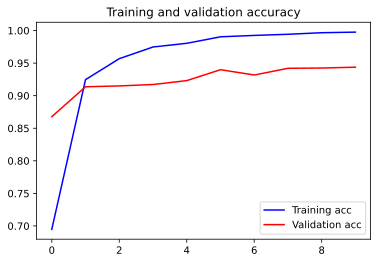

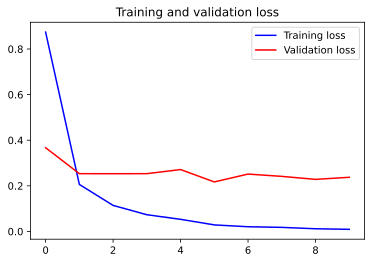

In [31]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

**Предсказываем на тестовых данных**

In [ ]:
test_sub_generator.samples

In [ ]:
test_sub_generator.reset()
predictions = model.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [ ]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission.csv', index=False)
print('Save submit')

score 0.92883

In [ ]:
submission.head()

**Добавим слой Batch-нормализации и посмотрим как это влияет на результат**

In [33]:
model2 = M.Sequential()
model2.add(base_model)
model2.add(L.GlobalAveragePooling2D(),)
model2.add(L.Dense(256, activation='relu'))
model2.add(L.BatchNormalization())
model2.add(L.Dropout(0.25))
model2.add(L.Dense(CLASS_NUM, activation='softmax'))

In [34]:
model2.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [35]:
history = model2.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/10
207/207 [==============================] - 296s 1s/step - loss: 0.3270 - accuracy: 0.9051 - val_loss: 0.2233 - val_accuracy: 0.9365

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
207/207 [==============================] - 285s 1s/step - loss: 0.0436 - accuracy: 0.9860 - val_loss: 0.3237 - val_accuracy: 0.9326

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
207/207 [==============================] - 283s 1s/step - loss: 0.0301 - accuracy: 0.9902 - val_loss: 0.3288 - val_accuracy: 0.9322

Epoch 00003: saving model to best_model.hdf5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Epoch 4/10
207/207 [==============================] - 285s 1s/step - loss: 0.0236 - accuracy: 0.9940 - val_loss: 0.2839 - val_accuracy: 0.9416

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
207/207 [==============================] - 283s 1s/step - loss: 0.0089 - accuracy: 0.9971 - val_loss: 0.2819 - val_accuracy: 0.9429

Epoch 00005: saving

In [36]:
scores = model2.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

37/37 [==============================] - 35s 933ms/step - loss: 0.2969 - accuracy: 0.9407
Accuracy: 94.07%


Accuracy: 94.07%

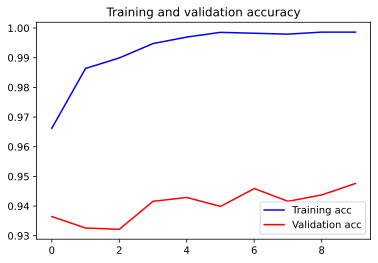

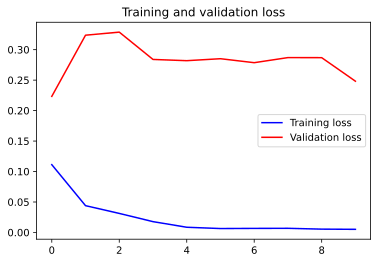

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

# **Применим fine-tuning**

# **шаг 1** (замороженная "голова" модель Xception)

In [38]:
base_model.trainable = False

In [39]:
model3 = M.Sequential()
model3.add(base_model)
model3.add(L.GlobalAveragePooling2D(),)
model3.add(L.Dense(256, activation='relu'))
model3.add(L.BatchNormalization())
model3.add(L.Dropout(0.25))
model3.add(L.Dense(CLASS_NUM, activation='softmax'))

In [40]:
model3.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [41]:
history = model3.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/10
207/207 [==============================] - 231s 1s/step - loss: 0.4365 - accuracy: 0.8760 - val_loss: 0.2352 - val_accuracy: 0.9403

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
207/207 [==============================] - 228s 1s/step - loss: 0.0110 - accuracy: 0.9980 - val_loss: 0.2666 - val_accuracy: 0.9416

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
207/207 [==============================] - 228s 1s/step - loss: 0.0053 - accuracy: 0.9989 - val_loss: 0.2913 - val_accuracy: 0.9386

Epoch 00003: saving model to best_model.hdf5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Epoch 4/10
207/207 [==============================] - 229s 1s/step - loss: 0.0035 - accuracy: 0.9992 - val_loss: 0.2880 - val_accuracy: 0.9438

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
207/207 [==============================] - 230s 1s/step - loss: 0.0035 - accuracy: 0.9995 - val_loss: 0.2981 - val_accuracy: 0.9416

Epoch 00005: saving

In [42]:
model3.save('../working/Xception_step1.hdf5')
model3.load_weights('best_model.hdf5')

In [43]:
scores = model3.evaluate_generator(test_generator, steps=1, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1/1 [==============================] - 1s 1s/step - loss: 0.5858 - accuracy: 0.9062
Accuracy: 90.62%


Accuracy: 90.62%

# **шаг2** (Размораживаем половину "головы" модель Xception)

In [44]:
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  132


In [45]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 60

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [46]:
model3.compile(loss="categorical_crossentropy", optimizer=optimizers.Adamax(lr=LR), metrics=["accuracy"])

In [47]:
history = model3.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/10
207/207 [==============================] - 249s 1s/step - loss: 0.0097 - accuracy: 0.9971 - val_loss: 0.3059 - val_accuracy: 0.9429

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
207/207 [==============================] - 245s 1s/step - loss: 0.0063 - accuracy: 0.9978 - val_loss: 0.3012 - val_accuracy: 0.9420

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
207/207 [==============================] - 243s 1s/step - loss: 0.0036 - accuracy: 0.9992 - val_loss: 0.3147 - val_accuracy: 0.9450

Epoch 00003: saving model to best_model.hdf5
Epoch 4/10
207/207 [==============================] - 242s 1s/step - loss: 0.0075 - accuracy: 0.9975 - val_loss: 0.3195 - val_accuracy: 0.9429

Epoch 00004: saving model to best_model.hdf5

Epoch 00004: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
Epoch 5/10
207/207 [==============================] - 241s 1s/step - loss: 0.0033 - accuracy: 0.9991 - val_loss: 0.3237 - val_accuracy: 0.9442

Epoch 00005: saving

In [48]:
model3.save('../working/Xception_step2.hdf5')
model3.load_weights('best_model.hdf5')

In [49]:
scores = model3.evaluate_generator(test_generator, steps=1, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1/1 [==============================] - 1s 1s/step - loss: 0.5133 - accuracy: 0.9062
Accuracy: 90.62%


Accuracy: 95.31%

# **Шаг3**** (Разморозим 75% "головы" модель Xception)

In [50]:
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 30

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [51]:
LR=0.00001
model3.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [52]:
history = model3.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/10
207/207 [==============================] - 253s 1s/step - loss: 0.0034 - accuracy: 0.9989 - val_loss: 0.3233 - val_accuracy: 0.9498

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
207/207 [==============================] - 249s 1s/step - loss: 0.0025 - accuracy: 0.9992 - val_loss: 0.3583 - val_accuracy: 0.9442

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
207/207 [==============================] - 247s 1s/step - loss: 0.0046 - accuracy: 0.9993 - val_loss: 0.3013 - val_accuracy: 0.9455

Epoch 00003: saving model to best_model.hdf5
Epoch 4/10
207/207 [==============================] - 247s 1s/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 0.3383 - val_accuracy: 0.9425

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
207/207 [==============================] - 248s 1s/step - loss: 0.0021 - accuracy: 0.9995 - val_loss: 0.3093 - val_accuracy: 0.9420

Epoch 00005: saving model to best_model.hdf5

Epoch 00005: ReduceLROnPlateau reducing learning rate 

In [53]:
model3.save('../working/Xception_step3.hdf5')
model3.load_weights('best_model.hdf5')

In [54]:
scores = model3.evaluate_generator(test_generator, steps=1, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1/1 [==============================] - 1s 1s/step - loss: 0.2206 - accuracy: 0.9844
Accuracy: 98.44%


Accuracy: 98.44%

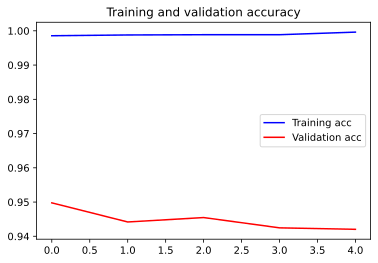

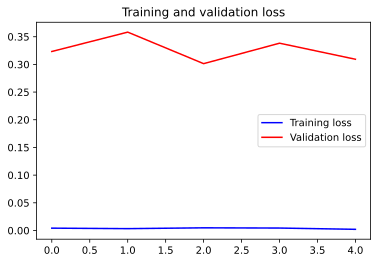

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

# **шаг 4** (Разморозим "голову" полностью, модель Xception)

In [56]:
base_model.trainable = True
LR=0.000001

In [57]:
model3.compile(loss="categorical_crossentropy", optimizer=optimizers.Adamax(lr=LR), metrics=["accuracy"])

In [58]:
history = model3.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/10
207/207 [==============================] - 289s 1s/step - loss: 0.0021 - accuracy: 0.9992 - val_loss: 0.3003 - val_accuracy: 0.9489

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
207/207 [==============================] - 284s 1s/step - loss: 0.0023 - accuracy: 0.9992 - val_loss: 0.3150 - val_accuracy: 0.9489

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
207/207 [==============================] - 284s 1s/step - loss: 0.0016 - accuracy: 0.9997 - val_loss: 0.3188 - val_accuracy: 0.9416

Epoch 00003: saving model to best_model.hdf5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 2.499999993688107e-07.
Epoch 4/10
207/207 [==============================] - 282s 1s/step - loss: 0.0029 - accuracy: 0.9990 - val_loss: 0.3053 - val_accuracy: 0.9472

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
207/207 [==============================] - 283s 1s/step - loss: 0.0018 - accuracy: 0.9996 - val_loss: 0.3061 - val_accuracy: 0.9438

Epoch 00005: saving

In [59]:
model3.save('../working/Xception_step4.hdf5')
model3.load_weights('best_model.hdf5')

In [60]:
scores = model3.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

37/37 [==============================] - 34s 917ms/step - loss: 0.3289 - accuracy: 0.9442
Accuracy: 94.42%


Accuracy: 94.42%

делаем предсказания 3-ей моделью на тестовых данных

In [ ]:
test_sub_generator.samples

In [ ]:
test_sub_generator.reset()
predictions = model3.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [ ]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission2.csv', index=False)
print('Save submit')

0.93722

In [ ]:
model4 = M.load_model('../working/Xception_step3.hdf5')

In [ ]:
scores = model4.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

In [ ]:
test_sub_generator.reset()
predictions = model4.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [ ]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission3.csv', index=False)
print('Save submit')

# **Попробуем использовать сети другой архитектуры.**
**FixEfficientNet-B7**

# **Шаг 1.** Заморозим "голову", модель B7.

In [8]:
pip install -q efficientnet

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-icigobas
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-icigobas
  Running command git submodule update --init --recursive -q
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33792 sha256=df5e55d090b883fdbfe33eb34f8a5e8d037888082f20101f65816705aaaa2e4f
  Stored in directory: /tmp/pip-ephem-wheel-cache-pylzsgg6/wheels/02/cd/18/61c0bbb8766acfec68f9d20618886b7b38dfeeb95865b6ba00
Successfully built segmentation-models
  Attempting uninstall: efficientnet
    Found existing installation: efficientnet 1.1.1
    Uninstalling efficientnet-1.1.1:
      Successfully uninstalled efficientnet-1.1.1
Note: you may need to restart the kernel to use updated packages.


In [10]:
import efficientnet.tfkeras as efn

In [11]:
base_model2 = efn.EfficientNetB7(weights='imagenet', include_top=False, input_shape = input_shape)

258441216/258434480 [==============================] - 3s 0us/step


In [64]:
# Для начала заморозим веса EfficientNetB7 и обучим только "голову". 
# Делаем это для того, чтобы хорошо обученные признаки на Imagenet не затирались в самом начале нашего обучения
base_model2.trainable = False

In [65]:
modelB7 = M.Sequential()
modelB7.add(base_model2)
modelB7.add(L.GlobalAveragePooling2D(),)
modelB7.add(L.Dense(256, activation='relu'))
modelB7.add(L.BatchNormalization())
modelB7.add(L.Dropout(0.25))
modelB7.add(L.Dense(CLASS_NUM, activation='softmax'))

In [66]:
modelB7.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

In [67]:
history = modelB7.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

Epoch 1/10
207/207 [==============================] - 278s 1s/step - loss: 3.1658 - accuracy: 0.1098 - val_loss: 2.3463 - val_accuracy: 0.1258

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
207/207 [==============================] - 256s 1s/step - loss: 3.0703 - accuracy: 0.1121 - val_loss: 2.4060 - val_accuracy: 0.1391

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
207/207 [==============================] - 256s 1s/step - loss: 2.9100 - accuracy: 0.1337 - val_loss: 2.3885 - val_accuracy: 0.1748

Epoch 00003: saving model to best_model.hdf5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 2.499999993688107e-07.
Epoch 4/10
207/207 [==============================] - 257s 1s/step - loss: 2.8989 - accuracy: 0.1368 - val_loss: 2.3971 - val_accuracy: 0.1748

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
207/207 [==============================] - 257s 1s/step - loss: 2.8922 - accuracy: 0.1263 - val_loss: 2.3856 - val_accuracy: 0.1730

Epoch 00005: saving

In [68]:
modelB7.save('../working/modelB7_step1.hdf5')
modelB7.load_weights('best_model.hdf5')

In [69]:
scores = modelB7.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

37/37 [==============================] - 39s 1s/step - loss: 2.3573 - accuracy: 0.1945
Accuracy: 19.45%


Accuracy: 67.63%

# **ШАГ 2** **Разморозим 50% "головы" модель B7**

In [70]:
print("Number of layers in the base model: ", len(base_model2.layers))

Number of layers in the base model:  806


In [71]:
base_model2.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 400

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model2.layers[:fine_tune_at]:
  layer.trainable =  False

In [74]:
LR                   = 1e-4
modelB7.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['accuracy'] , verbose = 1  , mode = 'max')
history = modelB7.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

modelB7.save('../working/modelB7_step2.hdf5')
modelB7.load_weights('best_model.hdf5')

scores = modelB7.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/10
207/207 [==============================] - 329s 1s/step - loss: 1.6467 - accuracy: 0.4460 - val_loss: 0.5410 - val_accuracy: 0.8094

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
207/207 [==============================] - 303s 1s/step - loss: 0.6524 - accuracy: 0.7684 - val_loss: 0.3496 - val_accuracy: 0.8905

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
207/207 [==============================] - 306s 1s/step - loss: 0.3971 - accuracy: 0.8589 - val_loss: 0.2677 - val_accuracy: 0.9068

Epoch 00003: saving model to best_model.hdf5
Epoch 4/10
207/207 [==============================] - 307s 1s/step - loss: 0.2806 - accuracy: 0.8988 - val_loss: 0.2392 - val_accuracy: 0.9193

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
207/207 [==============================] - 307s 1s/step - loss: 0.2277 - accuracy: 0.9173 - val_loss: 0.2200 - val_accuracy: 0.9317

Epoch 00005: saving model to best_model.hdf5
Epoch 6/10
207/207 [==============================] - 3

KeyboardInterrupt: 

Accuracy: 88.62%

# * ** ШАГ 3. Разморозим всю базовую модели для обучения, модель B7*

In [ ]:
base_model2.trainable = True

In [ ]:
EPOCHS               = 10  # эпох на обучение
LR                   = 1e-5
BATCH_SIZE           = 8 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU

In [ ]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

In [ ]:
modelB7.compile(loss="categorical_crossentropy", optimizer=optimizers.Adamax(lr=LR), metrics=["accuracy"])
checkpoint = ModelCheckpoint('best_model.hdf5' , monitor = ['accuracy'] , verbose = 1  , mode = 'max')
history = modelB7.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

modelB7.save('../working/modelB7_step3.hdf5')
modelB7.load_weights('best_model.hdf5')

In [ ]:
scores = modelB7.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 91.58%

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

Можно сказать, что сеть не дообучилась из-за маленького LR. Учтем это при дальнейших шагах, чтобы ускорить сходимость.

In [ ]:
test_sub_generator.reset()
predictions = modelB7.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [ ]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission3.csv', index=False)
print('Save submit')

# **Попробуем сменить функцию активации на GELU и дополнительно поработать с методами аугментации** делаем заново обучение по всем шагам**

In [12]:
!pip install --upgrade albumentations -q
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor -q

In [13]:
from ImageDataAugmentor.image_data_augmentor import *
import albumentations

In [15]:
EPOCHS               = 7  # эпох на обучение
BATCH_SIZE           = 64 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-4
VAL_SPLIT            = 0.15 # сколько данных выделяем на тест = 15%

CLASS_NUM            = 10  # количество классов в нашей задаче
IMG_SIZE             = 224 # какого размера подаем изображения в сеть
IMG_CHANNELS         = 3   # у RGB 3 канала
input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5)
])

train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT,
        )
        
test_datagen = ImageDataAugmentor(rescale=1./255)

In [16]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:332: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.


In [17]:
checkpoint = ModelCheckpoint('best_model.hdf5', 
                             monitor = ['val_accuracy'], 
                             verbose = 1,
                             mode = 'max')
earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 4,
                          restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.25,
                              patience=2,
                              min_lr=0.0000001,
                              verbose=1,
                              mode='auto')
callbacks_list = [checkpoint, earlystop, reduce_lr]

In [18]:
base_model2.trainable = False
modelB7_2 = M.Sequential()
modelB7_2.add(base_model2)
modelB7_2.add(L.GlobalAveragePooling2D(),)
modelB7_2.add(L.Dense(256, activation='gelu'))
modelB7_2.add(L.BatchNormalization())
modelB7_2.add(L.Dropout(0.25))
modelB7_2.add(L.Dense(CLASS_NUM, activation='softmax'))

modelB7_2.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])


history = modelB7_2.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

modelB7_2.save('../working/modelB7_2_step1.hdf5')
modelB7_2.load_weights('best_model.hdf5')

scores = modelB7_2.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/7
207/207 [==============================] - 191s 794ms/step - loss: 2.3316 - accuracy: 0.2549 - val_loss: 1.5968 - val_accuracy: 0.5406

Epoch 00001: saving model to best_model.hdf5
Epoch 2/7
207/207 [==============================] - 155s 748ms/step - loss: 1.6590 - accuracy: 0.4370 - val_loss: 1.1918 - val_accuracy: 0.6131

Epoch 00002: saving model to best_model.hdf5
Epoch 3/7
207/207 [==============================] - 152s 733ms/step - loss: 1.4948 - accuracy: 0.4970 - val_loss: 1.0592 - val_accuracy: 0.6483

Epoch 00003: saving model to best_model.hdf5
Epoch 4/7
207/207 [==============================] - 154s 741ms/step - loss: 1.4158 - accuracy: 0.5154 - val_loss: 0.9905 - val_accuracy: 0.6591

Epoch 00004: saving model to best_model.hdf5
Epoch 5/7
207/207 [==============================] - 155s 746ms/step - loss: 1.3497 - accuracy: 0.5357 - val_loss: 0.9613 - val_accuracy: 0.6617

Epoch 00005: saving model to best_model.hdf5
Epoch 6/7
207/207 [==========================

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


37/37 [==============================] - 23s 606ms/step - loss: 0.8868 - accuracy: 0.6977
Accuracy: 69.77%


Accuracy: 92.79%

# шаг 2 (повторяем заново) 50% головы

In [82]:
EPOCHS               = 7  # эпох на обучение
BATCH_SIZE           = 32 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-4

In [19]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.


In [20]:
checkpoint = ModelCheckpoint('best_model.hdf5', 
                             monitor = ['val_accuracy'], 
                             verbose = 1,
                             mode = 'max')
earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 4,
                          restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.25,
                              patience=2,
                              min_lr=0.0000001,
                              verbose=1,
                              mode='auto')
callbacks_list = [checkpoint, earlystop, reduce_lr]

In [21]:
base_model2.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 400

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model2.layers[:fine_tune_at]:
  layer.trainable =  False

modelB7_2.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])
history = modelB7_2.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

modelB7_2.save('../working/modelB7_2_step2.hdf5')
modelB7_2.load_weights('best_model.hdf5')

scores = modelB7_2.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/7
207/207 [==============================] - 236s 990ms/step - loss: 1.5730 - accuracy: 0.4859 - val_loss: 0.4758 - val_accuracy: 0.8377

Epoch 00001: saving model to best_model.hdf5
Epoch 2/7
207/207 [==============================] - 201s 971ms/step - loss: 0.5875 - accuracy: 0.7905 - val_loss: 0.3406 - val_accuracy: 0.8828

Epoch 00002: saving model to best_model.hdf5
Epoch 3/7
207/207 [==============================] - 199s 958ms/step - loss: 0.3609 - accuracy: 0.8711 - val_loss: 0.2833 - val_accuracy: 0.8995

Epoch 00003: saving model to best_model.hdf5
Epoch 4/7
207/207 [==============================] - 199s 959ms/step - loss: 0.2592 - accuracy: 0.9100 - val_loss: 0.2256 - val_accuracy: 0.9231

Epoch 00004: saving model to best_model.hdf5
Epoch 5/7
207/207 [==============================] - 199s 960ms/step - loss: 0.2092 - accuracy: 0.9237 - val_loss: 0.2172 - val_accuracy: 0.9292

Epoch 00005: saving model to best_model.hdf5
Epoch 6/7
207/207 [==========================

Accuracy: 95.28%

# **ШАГ 3 100% головы**

In [22]:
EPOCHS               = 7  # эпох на обучение
BATCH_SIZE           = 8 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 1e-4

In [23]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.
Found 6675 validated image filenames.


/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:455: UserWarning: Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` '


In [24]:
checkpoint = ModelCheckpoint('best_model.hdf5', 
                             monitor = ['val_accuracy'], 
                             verbose = 1,
                             mode = 'max')
earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 4,
                          restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.25,
                              patience=2,
                              min_lr=0.0000001,
                              verbose=1,
                              mode='auto')
callbacks_list = [checkpoint, earlystop, reduce_lr]

In [25]:
base_model2.trainable = True
modelB7_2.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])


history = modelB7_2.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

modelB7_2.save('../working/modelB7_2_step3.hdf5')
modelB7_2.load_weights('best_model.hdf5')

scores = modelB7_2.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

Epoch 1/7
1654/1654 [==============================] - 679s 388ms/step - loss: 0.5079 - accuracy: 0.8414 - val_loss: 0.1691 - val_accuracy: 0.9407

Epoch 00001: saving model to best_model.hdf5
Epoch 2/7
1654/1654 [==============================] - 642s 388ms/step - loss: 0.3568 - accuracy: 0.8838 - val_loss: 0.1548 - val_accuracy: 0.9515

Epoch 00002: saving model to best_model.hdf5
Epoch 3/7
1654/1654 [==============================] - 642s 388ms/step - loss: 0.2636 - accuracy: 0.9099 - val_loss: 0.1537 - val_accuracy: 0.9558

Epoch 00003: saving model to best_model.hdf5
Epoch 4/7
1654/1654 [==============================] - 641s 388ms/step - loss: 0.2378 - accuracy: 0.9195 - val_loss: 0.1360 - val_accuracy: 0.9571

Epoch 00004: saving model to best_model.hdf5
Epoch 5/7
1654/1654 [==============================] - 642s 388ms/step - loss: 0.1745 - accuracy: 0.9390 - val_loss: 0.1538 - val_accuracy: 0.9562

Epoch 00005: saving model to best_model.hdf5
Epoch 6/7
1654/1654 [==============

Accuracy: 96.31%

In [26]:
test_sub_generator.reset()
predictions = modelB7_2.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


835/835 [==============================] - 77s 86ms/step


In [27]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission5.csv', index=False)
print('Save submit')

Save submit


In [28]:
scores = modelB7_2.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

292/292 [==============================] - 24s 83ms/step - loss: 0.1253 - accuracy: 0.9631
Accuracy: 96.31%


У**величим размер подаваемого на вход изображения**

In [31]:
from ImageDataAugmentor.image_data_augmentor import *
import albumentations

In [40]:
EPOCHS               = 3  # эпох на обучение
BATCH_SIZE           = 2 # уменьшаем batch если сеть большая, иначе не поместится в память на GPU
LR                   = 5e-5

IMG_SIZE             = 512 # какого размера подаем изображения в сеть

input_shape          = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5)
])

train_datagen = ImageDataAugmentor(
        rescale=1./255,
        augment = AUGMENTATIONS,
        validation_split=VAL_SPLIT,
        )
        
test_datagen = ImageDataAugmentor(rescale=1./255)

In [41]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',      # директория где расположены папки с картинками 
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='training') # set as training data

test_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, seed=RANDOM_SEED,
    subset='validation') # set as validation data

Found 13232 images belonging to 10 classes.
Found 2329 images belonging to 10 classes.


In [42]:
checkpoint = ModelCheckpoint('best_model.hdf5', 
                             monitor = ['val_accuracy'], 
                             verbose = 1,
                             mode = 'max')
earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 4,
                          restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.25,
                              patience=2,
                              min_lr=0.0000001,
                              verbose=1,
                              mode='auto')
callbacks_list = [checkpoint, earlystop, reduce_lr]

In [43]:
base_model2 = efn.EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)

In [44]:
modelB7_2.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

modelB7_2.load_weights('best_model.hdf5') # Подгружаем ранее обученные веса

In [23]:
model42 = M.load_model('../input/modelb7/modelB7_2_step2.hdf5')

In [24]:
model42.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=LR), metrics=["accuracy"])

#modelB7_2.load_weights('../input/modelb7/modelB7_2_step2.hdf5') # Подгружаем ранее обученные веса

callbacks = callbacks_list

In [45]:
history = modelB7_2.fit_generator(
        train_generator,
        steps_per_epoch = len(train_generator),
        validation_data = test_generator, 
        validation_steps = len(test_generator),
        epochs = EPOCHS,
        callbacks = callbacks_list
)

modelB7_2.save('../working/modelB7_2_step4.hdf5')
modelB7_2.load_weights('best_model.hdf5')


Epoch 1/3
6616/6616 [==============================] - 3550s 531ms/step - loss: 0.9307 - accuracy: 0.7677 - val_loss: 0.1337 - val_accuracy: 0.9704

Epoch 00001: saving model to best_model.hdf5
Epoch 2/3
6616/6616 [==============================] - 3521s 532ms/step - loss: 0.6102 - accuracy: 0.8658 - val_loss: 0.1488 - val_accuracy: 0.9682

Epoch 00002: saving model to best_model.hdf5
Epoch 3/3
6616/6616 [==============================] - 3514s 531ms/step - loss: 0.5312 - accuracy: 0.8834 - val_loss: 0.1729 - val_accuracy: 0.9708

Epoch 00003: saving model to best_model.hdf5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.


NameError: name 'model' is not defined

In [47]:
scores = modelB7_2.evaluate_generator(test_generator, steps=len(test_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

1165/1165 [==============================] - 114s 97ms/step - loss: 0.1574 - accuracy: 0.9699
Accuracy: 96.99%


In [48]:
test_sub_generator.reset()
predictions = modelB7_2.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
predictions = np.argmax(predictions, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

835/835 [==============================] - 71s 80ms/step


In [49]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission6.csv', index=False)
print('Save submit')

Save submit


# **TTA**

In [51]:
modelB7_2.load_weights('best_model.hdf5')

In [52]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, interpolation=1, border_mode=4, value=None, mask_value=None, always_apply=False, p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=220, width=200),
        albumentations.CenterCrop(height=200, width=220),
    ],p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1)
    ],p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, always_apply=False, p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])
      
test_datagen = ImageDataAugmentor( 
    rescale=1./255,
    augment = AUGMENTATIONS,
    validation_split=VAL_SPLIT,
)

In [53]:
test_sub_generator = test_datagen.flow_from_dataframe( 
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    shuffle=False,
    class_mode=None,
    seed=RANDOM_SEED,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,)

Found 6675 validated image filenames.


In [54]:
tta_steps = 10 # берем среднее из 10 предсказаний
predictions = []

for i in range(tta_steps):
    preds = modelB7_2.predict_generator(test_sub_generator, steps=len(test_sub_generator), verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

3338/3338 [==============================] - 315s 94ms/step


In [57]:
predictions = np.argmax(pred, axis=-1) #multiple categories
label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) #flip k,v
predictions = [label_map[k] for k in predictions]

In [58]:
filenames_with_dir=test_sub_generator.filenames
submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, columns=['Id', 'Category'])
submission['Id'] = submission['Id'].replace('test_upload/','')
submission.to_csv('submission_TTA.csv', index=False)
print('Save submit')

Save submit


## **Выводы**

**Fine-tuning Xception**
* 0% головы разморожено accuracy 90,62%
* 50% головы разморожено accuracy 95,31%
* 75% головы разморожено accuracy 98,44%
* 100% головы разморожено accuracy 94,42%

**Fine-tuning EfficientNet7**
* 0% головы разморожено accuracy 69,73%
* 50% головы разморожено accuracy 95,28%
* 100% головы разморожено accuracy 96,31%
* Повышение размера картинки 96.99%%
* TTA accuracy %

**В проекте применены:**

* transfer learning и fine-tuning 
* дополнительные функции callback в Keras
* настройка LR
* применен способ заполнения пропусков c помощью ImageDataAugmentor с использованием библиотеки аугментации изображений albumentations
* подобраны переменные (размер картинки, батч, количество эпох)
* добавлена Batch Normalization в архитектуре “головы” модели
* SOTA архитектура сетей - EfficientNetB5
* добавлена TTA (Test Time Augmentation)
* Применены различные функции активации (relu, gelu)